In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/interpolated_data.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
num = 10


df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3
...,...,...,...,...,...
2020-06-26,0.0,-25.07,25.7,-29930.688,2.5
2020-06-27,0.0,-25.11,26.2,-31332.960,2.4
2020-06-28,0.0,-25.19,26.9,-32120.928,2.4


In [ ]:
features_cos = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_cos', 'month_cos', 'week_of_year_cos', 'quarter_cos', 'season_cos']
delete2 = [feature for feature in df.columns if feature not in features_cos]
df_cos = df.drop(delete2, axis=1)
features_new = ['Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry']
delete3 = [feature for feature in df_cos.columns if feature not in features_new]
df = df_cos.drop(delete3, axis=1)

In [2]:
target = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in target]

In [3]:
features

['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

In [4]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [5]:
testSize = int(0.3 * len(df))
testSize

1259

In [6]:
# Find the optimal ARIMAX model order using auto_arima
auto_model = auto_arima(
    train[target],
    exogenous=train[features],
    seasonal=False,  # Set to True for seasonal data
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,  # You can limit the search space for orders
    trace=True
)

# Get the selected order
order = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-8194.711, Time=2.92 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-6532.170, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-6966.605, Time=0.48 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-8172.641, Time=1.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-6534.170, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-8230.067, Time=1.98 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-8195.428, Time=1.48 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-8218.051, Time=2.10 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-8262.675, Time=2.23 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-8275.334, Time=3.41 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-8260.360, Time=3.65 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-8279.508, Time=3.57 sec
 ARIMA(1,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,2,5)(0,0,0)[0]        

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

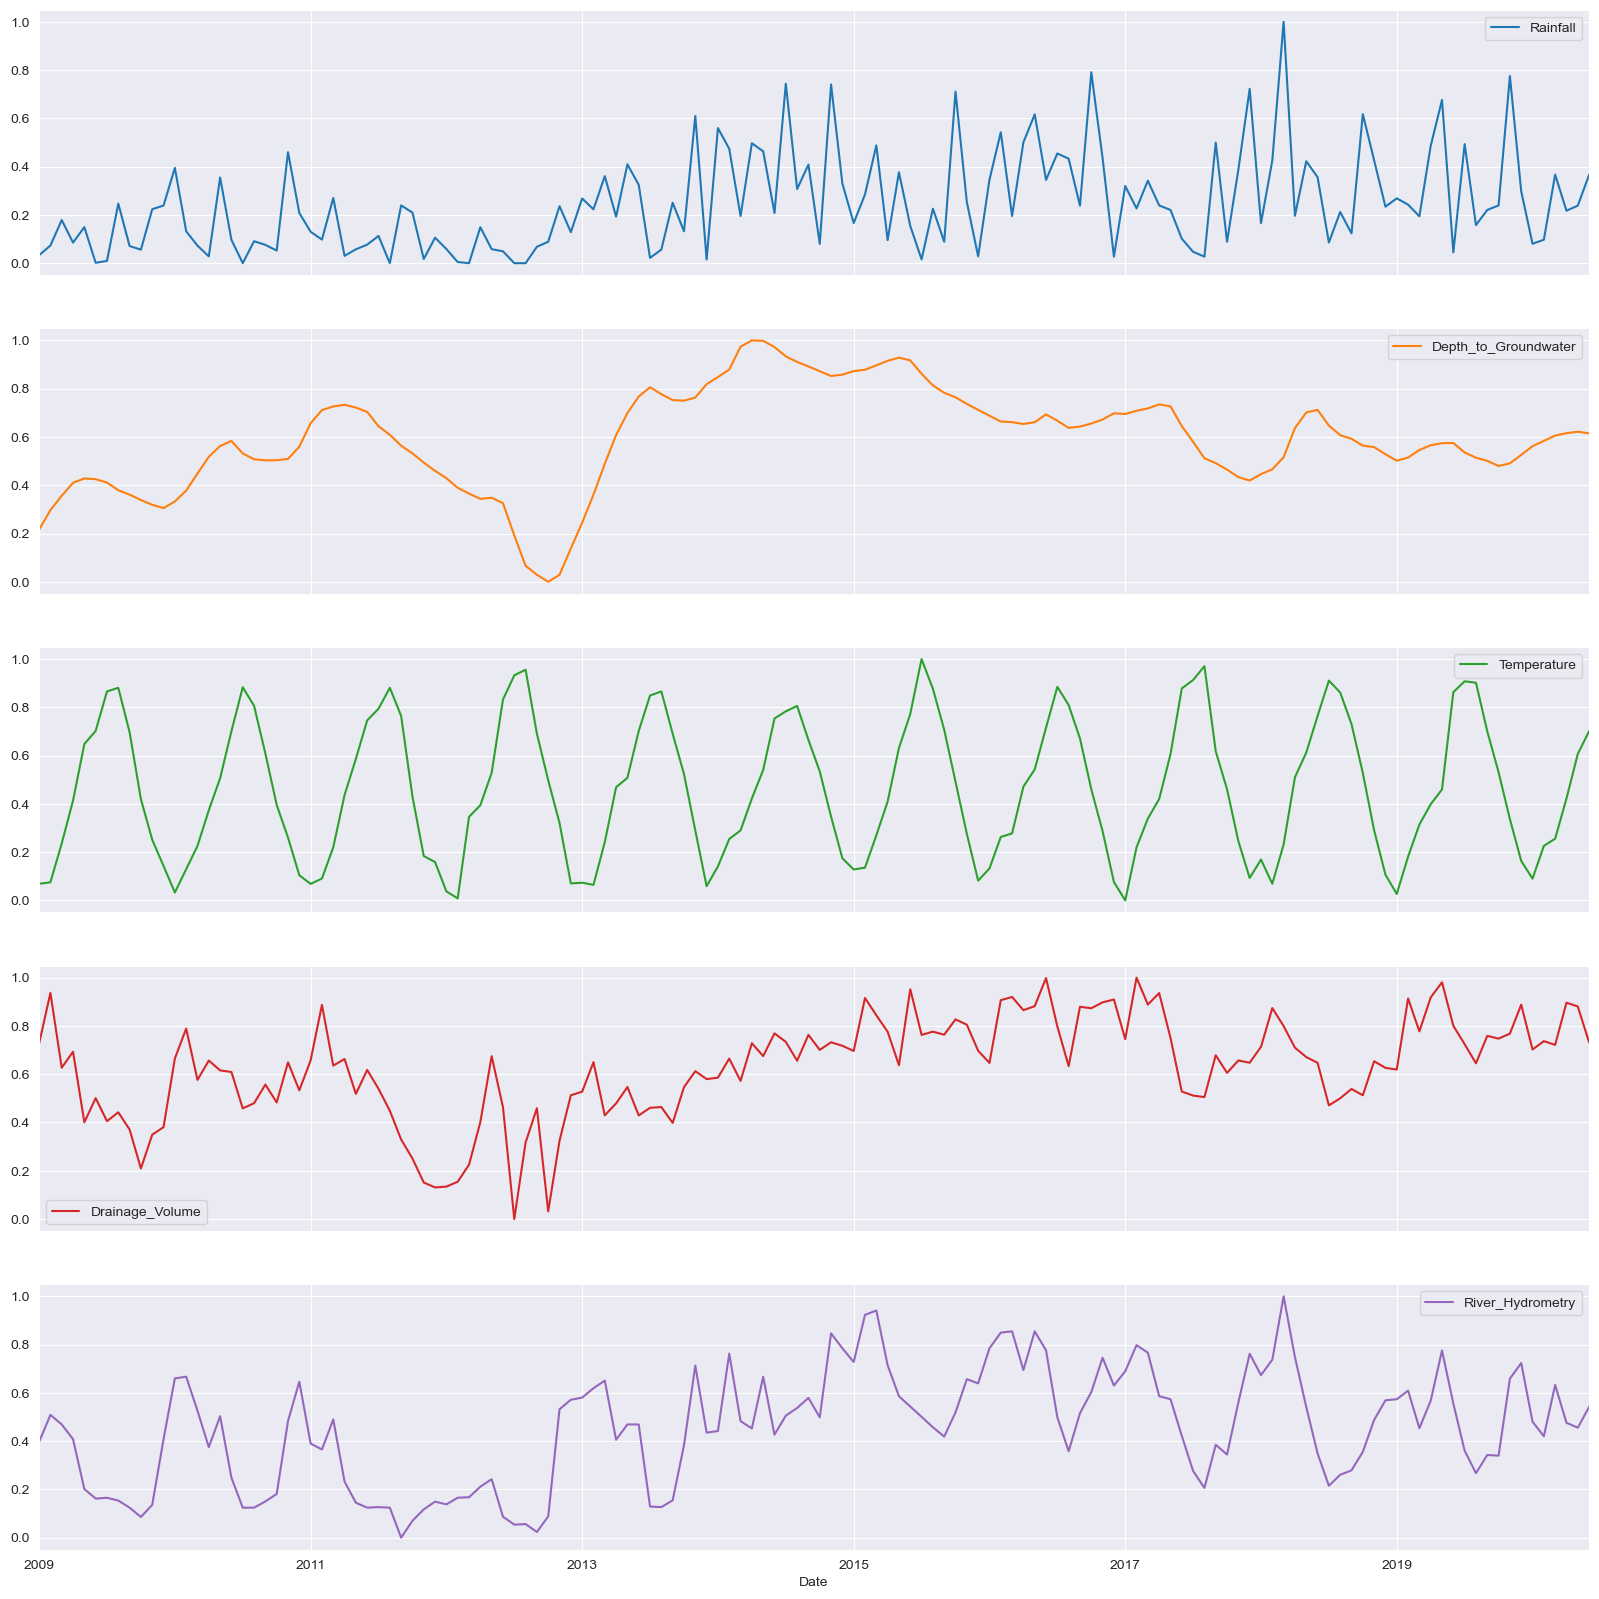

In [3]:
df.plot(subplots=True, figsize=(20, 20))

In [9]:
order

(1, 0, 1, 12)

In [7]:
#open text file
text_file = open("C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\order\\ARIMAX_order_"+str(num)+".txt", "w")

#write string to file
text_file.write(str(order))

#close file
text_file.close()

In [8]:
def fit_arimax(df):
    model = ARIMA(endog=df[target], exog=df[features], order=order)
    model=model.fit()
    return model

In [16]:
model = fit_arimax(train)
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test[features])

<Axes: xlabel='Date'>

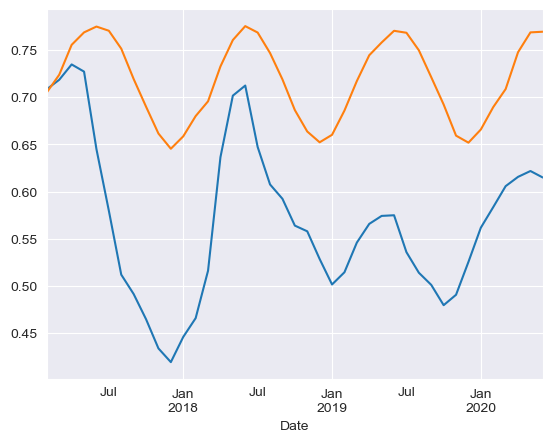

In [18]:

test['Depth_to_Groundwater'].plot(label=True)
predictions.plot(label=True)

In [9]:
# Rolling ARIMA algorithm
def arimax_roll():
    history = train.copy()
    predictions = pd.Series()

    for t in range(len(test)):
        model = fit_arimax(history)
        hat = model.forecast(steps=1, exog=history[features].iloc[[-1]])  # Forecast one step ahead
        predictions = predictions.append(hat)

        # Update history and exogenous history for the next iteration
        history = history.append(test.iloc[t])
    return predictions

In [ ]:
predictions = arimax_roll()

In [ ]:
predictions

In [ ]:
predictions.plot()
test['Depth_to_Groundwater'].plot()

In [ ]:
predictions.name = 'Depth_to_Groundwater'
predictions.to_csv('predictions/ARIMAX/'+str(num)+'.csv')

In [46]:
saved_sr = pd.read_csv('./predictions/ARIMA/'+str(num)+'.csv', index_col=0)
saved_sr.index = pd.to_datetime(saved_sr.index, format = '%Y-%m-%d')

FileNotFoundError: [Errno 2] No such file or directory: './predictions/ARIMA/12.csv'

In [ ]:
saved_sr = predictions

In [ ]:
metrics = {}
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':saved_sr, 'Actuals':df['Depth_to_Groundwater']}, index=saved_sr.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics['Depth_to_Groundwater'] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df

In [ ]:
metrics_df.to_csv('metrics/ARIMAX/'+str(num)+'.csv')

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

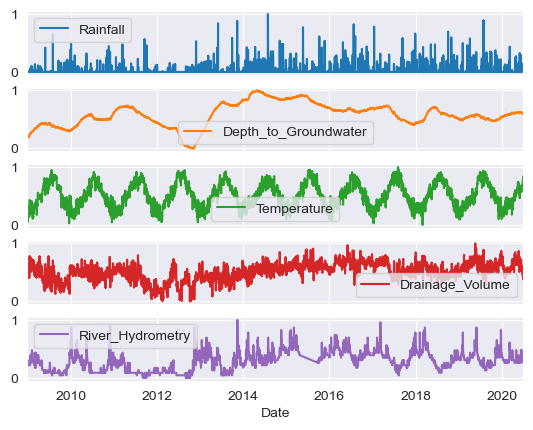

In [50]:
df.plot(subplots=True)

In [ ]:
import winsound
winsound.Beep(2500,1000)